In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def load_data_frame():

    with open("transport.csv", "r", newline="") as fp:
        reader = csv.reader(fp, delimiter=";")
        df = pd.DataFrame(reader)
        df = df.drop(labels=[0,1], axis=0)
        for i in range(11):
            df = df.drop(labels=[316 + i], axis=0)
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        df = df.drop(labels=["_Svar-ID", "Resume-Code", "Start", "Dato og tid", "Deltagerstatus"], axis=1)

        return df

In [3]:
def translate_data(df):

    old_column_names = ["1. Hvor gammel er du?", "2. Er du mand eller kvinde?", "3. Hvilken form for by bor du i?", "4. Hvad er din civil status?",
                        "5. Har du hjemmeboende børn?", "6. Har du bil?", "7. Har du en cykel?", "8. Hvilken form for transport bruger du mest når du skal rundt i egen by?",
                        "9. Hvilken form for transport bruger du mest når du skal ud for egen by?", "10. Hvor langt har du til arbejde?",
                        "11. Hvilken form for transport bruger du mest til og fra arbejde?", "12. Hvor langt har du til skole?",
                        "13. Hvilken form for transport bruger du mest til og fra skole?", "14. Har parkerings muligheder indflydelse på dit valg af transport?",
                        "15. Hvis det er en solskinsdag - vælg det udsagn der passer bedst", "16. Hvis det er en regnvejrsdag - vælg det udsagn der passer bedst"]

    new_column_names = ["Age", "Gender", "City", "Civil status", "Kids living at home", "Owns a car", "Owns a bike", "Kind of transport within own city",
                        "Kind of transport outside own city", "Distance to work", "Transport to and from work", "Distance to school", "Transport to and from school",
                        "Does parkings have an influence", "Statement on a shiny day", "Statement on a rainy day"]

    for i in range(len(new_column_names)):
        df = df.rename(columns={old_column_names[i]:new_column_names[i]})

    df['Gender'] = df['Gender'].map({'Mand': 'Male', 'Kvinde': 'Female'})
    df['City'] = df['City'].map({'Forstad': 'Suburb', 'Storby': 'Big city', 'Landet': 'Country'})
    df['Civil status'] = df['Civil status'].map({'Single': 'Single', 'I forhold': 'In relationship', 'Ved ikke': 'Dont know'})
    df['Kids living at home'] = df['Kids living at home'].map({'ja': 'yes', 'nej': 'no'})
    df['Owns a car'] = df['Owns a car'].map({'ja': 'yes', 'nej': 'no'})
    df['Owns a bike'] = df['Owns a bike'].map({'ja': 'yes', 'nej': 'no'})
    df['Kind of transport within own city'] = df['Kind of transport within own city'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Andet': 'Other'})
    df['Kind of transport outside own city'] = df['Kind of transport outside own city'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Andet': 'Other'})
    df['Distance to work'] = df['Distance to work'].map({'Under 1 km': 'Under 1 km', 'Mellem 1-5 km': 'Between 1-5 km', 'Mellem 5-15 km': 'Between 5-15 km',
                                                         'Mellem 15-25 km': 'Between 15-25 km', 'Mellem 25-40 km': 'Between 25-40 km', 'Over 40 km': 'Over 40 km',
                                                         'Jeg arbejdeder kun hjemmefra': 'I only work from home', 'Jeg har ikke noget arbejde': 'I dont have a job'})
    df['Transport to and from work'] = df['Transport to and from work'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Jeg har ikke noget arbejde':
                                                                                 'I dont have a job', 'Andet': 'Other'})
    df['Distance to school'] = df['Distance to school'].map({'Under 1 km': 'Under 1 km', 'Mellem 1-5 km': 'Between 1-5 km', 'Mellem 5-15 km': 'Between 5-15 km',
                                                         'Mellem 15-25 km': 'Between 15-25 km', 'Mellem 25-40 km': 'Between 25-40 km', 'Over 40 km': 'Over 40 km',
                                                        'Jeg går ikke i skole': 'I dont go to school'})
    df['Transport to and from school'] = df['Transport to and from school'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Jeg går ikke i skole':
                                                                                 'I dont go to school', 'Andet': 'Other'})
    df['Does parkings have an influence'] = df['Does parkings have an influence'].map({'Ja': 'yes', 'Nej': 'no', 'Ved ikke': 'Dont know'})

    df['Statement on a shiny day'] = df['Statement on a shiny day'].map({'Jeg går eller cykler altid hvis afstanden passer til det': 'Walk/bike alwas if the weather fits',
                                                                         'Jeg går eller cykler en gang imellem hvis afstanden passer til det': 'Walk/bike sometimes if the weather fits',
                                                                         'Jeg går eller cykler sjældent også selvom afstanden passer til det': 'Walk/bike rarely even if the weather fits',
                                                                         'Jeg tager stort set altid tog, bus eller bil': 'Always train, bus or car',
                                                                         'Ved ikke': 'Dont know'})
    df['Statement on a rainy day'] = df['Statement on a rainy day'].map({'Jeg går eller cykler altid hvis afstanden passer til det': 'Walk/bike alwas if the weather fits',
                                                                         'Jeg går eller cykler en gang imellem hvis afstanden passer til det': 'Walk/bike sometimes if the weather fits',
                                                                         'Jeg går eller cykler sjældent også selvom afstanden passer til det': 'Walk/bike rarely even if the weather fits',
                                                                         'Jeg tager stort set altid tog, bus eller bil': 'Always train, bus or car',
                                                                         'Ved ikke': 'Dont know'})
    
    return df

In [4]:
def calculate_chart(df, y_value, x_value, result_value, chart):
    
    df_1 = df[[x_value]]
    df_1["all"] = 1
    df_1 = df_1.groupby([x_value], as_index=False)["all"].count()

    df_2 = df[[x_value, y_value]]
    df_2["counter"] = 1
    df_2 = df_2.groupby([x_value, y_value], as_index=False)["counter"].count()

    df_3 = df_2.loc[df_2[y_value] == result_value]
    df_3 = pd.merge(df_3, df_1, left_on=x_value, right_on=x_value, how='inner')
    df_3["percent"] = df_3['counter'] * 100 / df_3["all"]
    
    plt.ylabel("Percent %")
    plt.xlabel(x_value)
    plt.xticks(rotation=45)
    plt.title("This is the how many travel by " + result_value + ", measured in percent")
    
    if chart == "plot":
        return df_3, plt.plot(df_3[x_value], df_3["percent"])
    elif chart == "bar":
        return df_3, plt.bar(df_3[x_value], df_3["percent"])
    elif chart == "scatter":
        return df_3, plt.scatter(df_3[x_value], df_3["percent"])


In [5]:

df = load_data_frame()
df = translate_data(df)
#pd.set_option('max_row', None)
df

2,Age,Gender,City,Civil status,Kids living at home,Owns a car,Owns a bike,Kind of transport within own city,Kind of transport outside own city,Distance to work,Transport to and from work,Distance to school,Transport to and from school,Does parkings have an influence,Statement on a shiny day,Statement on a rainy day,
3,15 - 25,Male,Big city,Single,no,no,yes,Bike,Train,Between 1-5 km,Bike,Under 1 km,I walk/run,no,Walk/bike alwas if the weather fits,Walk/bike sometimes if the weather fits,
4,Over 60,Male,Suburb,In relationship,no,yes,yes,Car,Car,Between 5-15 km,Car,I dont go to school,I dont go to school,yes,Walk/bike sometimes if the weather fits,"Always train, bus or car",
5,36 - 45,Female,Big city,Single,no,no,yes,Bike,Train,Under 1 km,Bike,I dont go to school,I dont go to school,no,Walk/bike alwas if the weather fits,"Always train, bus or car",
6,36 - 45,Female,Suburb,In relationship,yes,yes,yes,Car,Car,Over 40 km,Car,Between 1-5 km,Car,yes,NaN,"Always train, bus or car",
7,26 - 35,Female,Big city,In relationship,no,yes,yes,Train,Car,Between 5-15 km,Train,I dont go to school,I dont go to school,yes,Walk/bike alwas if the weather fits,Walk/bike rarely even if the weather fits,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,Over 60,Male,Suburb,In relationship,no,yes,yes,Car,Car,Under 1 km,I walk/run,I dont go to school,I dont go to school,yes,Walk/bike sometimes if the weather fits,"Always train, bus or car",
312,Over 60,Male,Suburb,In relationship,yes,yes,no,Car,Car,Between 5-15 km,Car,I dont go to school,I dont go to school,yes,"Always train, bus or car","Always train, bus or car",
313,Over 60,Male,Suburb,In relationship,no,yes,no,Car,Car,I only work from home,I dont have a job,I dont go to school,I dont go to school,yes,"Always train, bus or car","Always train, bus or car",
314,45 - 60,Female,Country,Single,yes,yes,yes,Car,Car,I only work from home,Other,Between 5-15 km,Car,yes,"Always train, bus or car","Always train, bus or car",


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


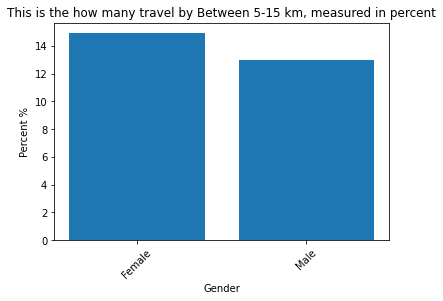

In [36]:
df_3, plot = calculate_chart(df, "Distance to work", "Gender", "Between 5-15 km", "bar")